Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best XGBoost Parameters: {'xgb__subsample': 0.9, 'xgb__reg_lambda': 1.0, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 300, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.2, 'xgb__colsample_bytree': 0.8}
📊 Model Performance:
🔹 Train R² Score: 0.7998
🔹 Test R² Score: 0.7284
🔹 Test MAE: 1215.77
🔹 Test RMSE: 1733.14


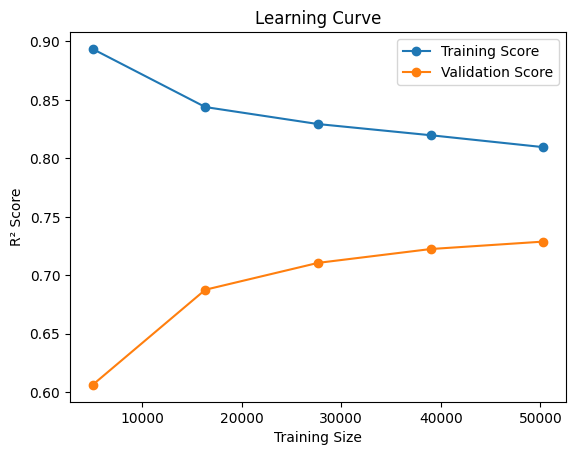

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import numpy as np

# Load Data
df = pd.read_csv('final_data.csv')

# Drop Years
years_to_drop = [2001, 2002, 2004, 2005, 2009, 2010, 2011, 2013, 2014]
df = df[~df['Year'].isin(years_to_drop)]

#df['Mid_Price']=(df['Max_Price']+df['Min_Price'])/2

# Outlier Removal (Mid Price)
Q1_max = df['Max_Price'].quantile(0.25)
Q3_max = df['Max_Price'].quantile(0.75)
IQR_max = Q3_max - Q1_max
df = df[~((df['Max_Price'] < (Q1_max - 1.5 * IQR_max)) | (df['Max_Price'] > (Q3_max + 1.5 * IQR_max)))]

# Feature and Target Definition
X = df[['State', 'Commodity', 'Year', 'Month', 'Rainfall', 'Max_Temp', 'Min_Temp', 'Predominant Soil Types', 'Humidity']]
y = df['Max_Price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Column Transformer for Encoding and Scaling
categorical_cols = ['State', 'Commodity', 'Predominant Soil Types']
numerical_cols = ['Year', 'Month', 'Rainfall', 'Max_Temp', 'Min_Temp', 'Humidity']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

# XGBoost Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparameter Grid
xgb_params = {
    'xgb__n_estimators': [50, 100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
    'xgb__reg_alpha': [0.1],
    'xgb__reg_lambda': [1.0]
}

# Randomized Search
xgb_search = RandomizedSearchCV(pipeline, xgb_params, n_iter=10, cv=3, scoring='r2', n_jobs=-1, verbose=2, random_state=42)

# Train Model
xgb_search.fit(X_train, y_train)

# Best Model
best_pipeline = xgb_search.best_estimator_
print(f"✅ Best XGBoost Parameters: {xgb_search.best_params_}")

# Predictions
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print Results
print(f"📊 Model Performance:")
print(f"🔹 Train R² Score: {train_r2:.4f}")
print(f"🔹 Test R² Score: {test_r2:.4f}")
print(f"🔹 Test MAE: {test_mae:.2f}")
print(f"🔹 Test RMSE: {test_rmse:.2f}")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_pipeline, X_train, y_train, cv=5, scoring='r2')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [2]:
import joblib
from joblib import dump,load

dump(best_pipeline, 'maxcrop_price_model.joblib')

['maxcrop_price_model.joblib']